## 학습 목표
- 텍스트 데이터를 머신러닝 입출력용 수치데이터로 변환
- RNN의 특징을 이해하고 시퀀셜한 데이터를 다루는 방법
- 1-D CNN으로도 텍스트를 처리
- IMDB와 네이버 영화리뷰 데이터셋을 이용한 영화리뷰 감성 분류 실습

### 텍스트 데이터 특징
- 텍스트를 어떻게 숫자 행렬로 표현하는가
- 텍스트 데이터의 순서를 어떻게 반영하는가
- **Encoding과 Embedding**

### 텍스트 숫자로 표현하기
- i feel hungry
- i eat lunch
- now i feel happy

In [1]:
sentences = ['i feel hungry', 'i eat lunch', 'now i feel happy']

# split() 메소드로 단어 단위로 문장 쪼개기
word_list = 'i feel hungty'.split()
print(word_list)

['i', 'feel', 'hungty']


**모든 문장을 단어 단위로 쪼갠 후에 딕셔너리로 표현**

In [2]:
index_to_word = {}

# 단어를 채워보자. 단어의 순서는 크게 중요하지 않아서 일단 넣어보자
# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어준다
index_to_word[0] = '<PAD>' # 패딩용 단어
index_to_word[1] = '<BOS>' # 문장의 시작 지점
index_to_word[2] = '<UNK>' # 사전에 없는(unknown) 단어
index_to_word[3]='i'
index_to_word[4]='feel'
index_to_word[5]='hungry'
index_to_word[6]='eat'
index_to_word[7]='lunch'
index_to_word[8]='now'
index_to_word[9]='happy'

print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: 'i', 4: 'feel', 5: 'hungry', 6: 'eat', 7: 'lunch', 8: 'now', 9: 'happy'}


**텍스트 데이터를 숫자로 바꾸려면 {텍스트 : 인덱스} 구조여야 한다**

In [3]:
word_to_index = {word:index for index, word in index_to_word.items()}
print(word_to_index)

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, 'i': 3, 'feel': 4, 'hungry': 5, 'eat': 6, 'lunch': 7, 'now': 8, 'happy': 9}


In [4]:
print(word_to_index['feel'])

4


**가지고 있는 덱스트 데이터를 숫자로 바꾸기**

In [6]:
# 딕셔너리를 주면 단어 인덱스 리스트로 바꿔주는 함수 만들기
# 모든 문장은 <BOS>로 시작한다
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('i eat lunch', word_to_index))

[1, 3, 6, 7]


In [7]:
# 여러 개의 문장을 한꺼번에 숫자 텐서로 encode 해주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]]


**encode된 벡터를 decode 할 수 있다**

In [8]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    #[1:]를 통해 <BOS>를 제외
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

i feel hungry


In [11]:
# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

print(get_decoded_sentences(encoded_sentences, index_to_word))

['i feel hungry', 'i eat lunch', 'now i feel happy']


### Embedding 레이어

**Embedding**
- 단어를 벡터로 표현한 것
- 단어나 문장 사이의 유사도와 관계도를 표현할 수 있다

- Embedding 레이어의 인풋 되는 문장의 **길이는 모두 일정해야 한다**
- 길이가 부족한 문장 뒤에는 **PAD를 추가해서 길이를 맞춘다**  

아래 코드는 길이가 일정하지 않아 오류가 발생한 것이다

In [13]:
# 아래 코드는 그대로 실행하시면 에러가 발생한다

import numpy as np
import tensorflow as tf
import os

vocab_size = len(word_to_index) # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4 

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# 숫자로 변환된 텍스트 데이터 [[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 에 Embedding 레이어를 적용한다
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype='object')
output = embedding(raw_inputs)
print(output)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [15]:
# <PAD>로 문장의 길이를 일정하게 만들어 주었다
raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs, value=word_to_index['<PAD>'], padding='post', maxlen=5)
print(raw_inputs)

[[1 3 4 5 0]
 [1 3 6 7 0]
 [1 8 3 4 9]]


In [16]:
vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 그림과 같이 4차원의 워드 벡터를 가정한다

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# tf.keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정 길이로 맞춰야 한다
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype=object)
raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs, value=word_to_index['<PAD>'], padding='post', maxlen=5)
output = embedding(raw_inputs)
print(output)

tf.Tensor(
[[[ 0.02009082 -0.01975288 -0.00067145  0.03414473]
  [-0.04176312 -0.04593537 -0.04382622 -0.01151173]
  [ 0.00814458 -0.03090158 -0.0470452  -0.01596105]
  [-0.01509293 -0.04426188 -0.02540473  0.02565997]
  [ 0.04241779  0.02801966  0.04309988  0.02708824]]

 [[ 0.02009082 -0.01975288 -0.00067145  0.03414473]
  [-0.04176312 -0.04593537 -0.04382622 -0.01151173]
  [-0.04714891  0.03506033  0.01378522  0.04048568]
  [ 0.04273256  0.02387379 -0.04665251  0.03080188]
  [ 0.04241779  0.02801966  0.04309988  0.02708824]]

 [[ 0.02009082 -0.01975288 -0.00067145  0.03414473]
  [-0.01319989 -0.0015322   0.01994855 -0.03699581]
  [-0.04176312 -0.04593537 -0.04382622 -0.01151173]
  [ 0.00814458 -0.03090158 -0.0470452  -0.01596105]
  [-0.01076082  0.0373866   0.00424945 -0.00418233]]], shape=(3, 5, 4), dtype=float32)


- 3은 입력문장 개수
- 5는 입력문장의 최대 길이
- 4는 워드 벡터의 차원 수

### RNN

In [17]:
# 어휘 사전의 크기 (단어 10개)
vocab_size = 10
# 단어 하나를 표현하는 임베딩 벡터의 차원수
word_vector_dim = 4

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
 # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용했다. 이때 LSTM state 벡터의 차원수는 8로 했다(변경 가능)
model.add(tf.keras.layers.LSTM(8))
model.add(tf.keras.layers.Dense(8, activation='relu'))
# 긍정, 부적을 나타내는 이진 분류라서 뉴련은 1이다
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


### 1D CNN
- CNN 계열이 RNN 계열보다 병렬처리가 효율적이기 때문에 학습 소도가 훨씬 빠르다

In [42]:
# 어휘 사전의 크기 (단어 10개)
vocab_size = 10
# 단어 하나를 표현하는 임베딩 벡터의 차원수
word_vector_dim = 4 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          464       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

## IMDB 영화리뷰 감성 분석

In [19]:
imdb = tf.keras.datasets.imdb

# IMDb 데이터셋 다운로드 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print(f"훈련 샘플 개수: {len(x_train)}, 테스트 개수: {len(x_test)}")

17473536/17464789 [==============================] - 0s 0us/step
훈련 샘플 개수: 25000, 테스트 개수: 25000


In [20]:
# 1번째 리뷰 데이터
print(x_train[0])
print('라벨', y_train[0])
print('1번째 리뷰 문장 길이 : ', len(x_train[0]))
print('2번째 리뷰 문장 길이 : ', len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨 1
1번째 리뷰 문장 길이 :  218
2번째 리뷰 문장 길이 :  189


- 텍스트 데이터가 아닌 숫자로 encode된 텍스트 데이터를 다운로드 했다
- 텍스트가 encode가 되서 IMDb는 딕셔너리도 함께 제공한다

In [21]:
word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}
# 'the'가 출력된다
print(index_to_word[1])
# 1이 출력된다
print(word_to_index['the'])

the
1


In [22]:
# 보정 전 x_train[0] 데이터
print(get_decoded_sentence(x_train[0], index_to_word))

as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but and to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other and in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of and odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one bit then have two of

- word_to_index, iodex_to_word는 보정이 필요하다

In [23]:
# 인코딩 인덱스는 3칸씩 뒤로 밀려 있다
# 이걸 고려해서 3칸씩 밀어서 출력하면 잘 나온다
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])      # '<BOS>'가 출력된다 
print(word_to_index['the'])  # 4가 출력된다
print(index_to_word[4])      # 'the'가 출력된다

# 보정 후 x_train[0] 데이터
print(get_decoded_sentence(x_train[0], index_to_word))

<BOS>
4
the
this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for

- encode된 텍스트가 정상적으로 decode되는지 확인한다
- 위 아래에 출력된 문장을 보면 잘 되었는지 아닌지 알 수 있다

In [24]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

- **pad_sequences로 문장의 길이를 통일해야 한다**
- 문장 최대 길이 maxlen의 설정도 모델 성능에 영향을 미치기 때문에 적절한 값을 찾아야한다
- 적절한 길이를 찾기 위해서 전체 데이터셋의 분표를 확인하는 것도 좋은 방법 중 하나이다

In [25]:
total_data_text = list(x_train) + list(x_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산한다
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


- **padding 방식을 문장 뒤쪽(post)과 앞쪽(pre)** 어느 쪽으로 하느냐에 따라 모델의 성능 차이가 발생한다
- 두가지 방식을 한번씩 적용해서 학습 시켜보고 비교하는 것이 좋다

In [26]:
# 뒤쪽(post)에서 했을 때이다
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, value=word_to_index["<PAD>"], padding='post', maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, value=word_to_index["<PAD>"], padding='post', maxlen=maxlen)
print(x_train.shape)

(25000, 580)


In [27]:
# 앞쪽(pre)에서 했을 때이다
x_train_pre = tf.keras.preprocessing.sequence.pad_sequences(x_train, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)
x_test_pre = tf.keras.preprocessing.sequence.pad_sequences(x_test, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)
print(x_train_pre.shape)

(25000, 580)


### IMDB 딥러닝 모델 설계와 훈련

- 일단 RNN 먼저 해보자
- 코드는 위에서 고대로 가져왔다

In [28]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
 # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용했다. 이때 LSTM state 벡터의 차원수는 8로 했다(변경 가능)
model.add(tf.keras.layers.LSTM(8))
model.add(tf.keras.layers.Dense(8, activation='relu'))
# 긍정, 부적을 나타내는 이진 분류라서 뉴련은 1이다
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [29]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


In [30]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 28s 72ms/step - loss: 0.6931 - accuracy: 0.5031 - val_loss: 0.6933 - val_accuracy: 0.5016
Epoch 2/20
30/30 [==============================] - 2s 51ms/step - loss: 0.6928 - accuracy: 0.5148 - val_loss: 0.6931 - val_accuracy: 0.5013
Epoch 3/20
30/30 [==============================] - 2s 51ms/step - loss: 0.6923 - accuracy: 0.5148 - val_loss: 0.6927 - val_accuracy: 0.5010
Epoch 4/20
30/30 [==============================] - 2s 51ms/step - loss: 0.6915 - accuracy: 0.5174 - val_loss: 0.6929 - val_accuracy: 0.5037
Epoch 5/20
30/30 [==============================] - 2s 52ms/step - loss: 0.6896 - accuracy: 0.5109 - val_loss: 0.6920 - val_accuracy: 0.5028
Epoch 6/20
30/30 [==============================] - 2s 51ms/step - loss: 0.6851 - accuracy: 0.5206 - val_loss: 0.6905 - val_accuracy: 0.5046
Epoch 7/20
30/30 [==============================] - 1s 50ms/step - loss: 0.6760 - accuracy: 0.5315 - val_loss: 0.6883 - val_accuracy: 0.5111
Epoch 8/20
3

- 테스트셋 평가

In [31]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

782/782 - 5s - loss: 0.7065 - accuracy: 0.5133
[0.7064535021781921, 0.5133200287818909]


In [32]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


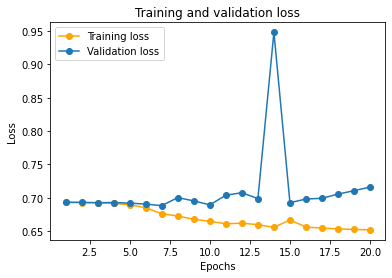

In [36]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, label='Training loss', color='orange', marker='o')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, label='Validation loss', marker='o')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

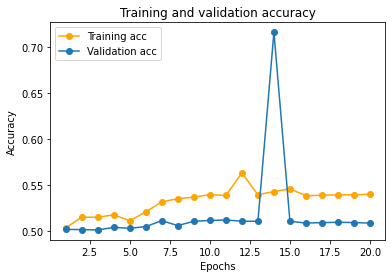

In [37]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, label='Training acc', color='orange', marker='o')
plt.plot(epochs, val_acc, label='Validation acc', marker='o')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [50]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [43]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 18s 26ms/step - loss: 0.6929 - accuracy: 0.5189 - val_loss: 0.6926 - val_accuracy: 0.5067
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.6924 - accuracy: 0.5249 - val_loss: 0.6919 - val_accuracy: 0.5409
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.6914 - accuracy: 0.5247 - val_loss: 0.6906 - val_accuracy: 0.5570
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.6899 - accuracy: 0.5480 - val_loss: 0.6888 - val_accuracy: 0.5247
Epoch 5/20
30/30 [==============================] - 0s 14ms/step - loss: 0.6875 - accuracy: 0.5505 - val_loss: 0.6862 - val_accuracy: 0.5498
Epoch 6/20
30/30 [==============================] - 0s 14ms/step - loss: 0.6847 - accuracy: 0.5639 - val_loss: 0.6839 - val_accuracy: 0.5570
Epoch 7/20
30/30 [==============================] - 0s 13ms/step - loss: 0.6818 - accuracy: 0.5733 - val_loss: 0.6809 - val_accuracy: 0.5672
Epoch 8/20
3

In [44]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

782/782 - 1s - loss: 0.6677 - accuracy: 0.5911
[0.6676796674728394, 0.5910800099372864]


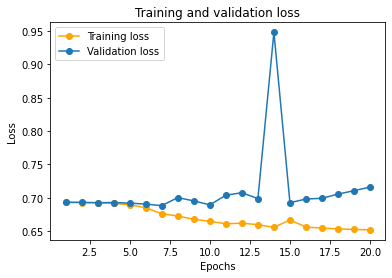

In [46]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.clf()   # 그림을 초기화합니다

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, label='Training loss', color='orange', marker='o')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, label='Validation loss', marker='o')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

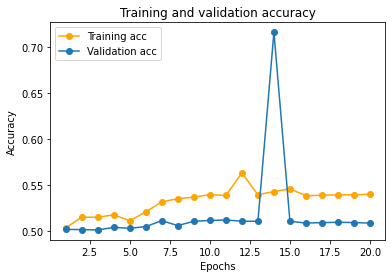

In [47]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, label='Training acc', color='orange', marker='o')
plt.plot(epochs, val_acc, label='Validation acc', marker='o')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Word2Vec 적용

In [51]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [52]:
# 학습한 Embedding 파라미터를 파일에 써서 저장한다
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 쓴다

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록힌다
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

- gensim에서 제동하는 패키지를 사용해서 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용할 수 있다


In [53]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([-0.12443902,  0.05736512,  0.13506377, -0.11338655, -0.04230377,
       -0.10613071,  0.02809541, -0.1245093 , -0.06210124,  0.04448931,
        0.05115405, -0.04840734, -0.10965922,  0.0871869 , -0.11414555,
       -0.07520733], dtype=float32)

- 워드 벡터를 가지고 의미 벡터 공간상에 유의미하게 학습되었는지 확인할 수 있다
- 단어를 하나 주고 가장 유사한 단어와의 유사도를 확인하는 방법이다

In [54]:
word_vectors.similar_by_word("love")

[('stardom', 0.8076601624488831),
 ('1951', 0.8024081587791443),
 ('emerges', 0.8005027770996094),
 ('stirring', 0.7854864001274109),
 ('a', 0.7802442312240601),
 ('eli', 0.7755715250968933),
 ('whenever', 0.7688738107681274),
 ('realise', 0.7642790675163269),
 ('aid', 0.7626829147338867),
 ("che's", 0.760640561580658)]

- 그닥 비슷하게 찾은 것 같지는 않다

- 구글의 Word2Vec 모델을 가져왔다
- 단어가 엄청 많아서 메모리 에러가 날 수 있어 리미트(limit)을 100만으로 지정했다

In [55]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

- **양이 많아 불안해서 실습은 lms에서 하는 걸로**

In [ ]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("love")

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

In [ ]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

In [ ]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

- 결과는 확실히 이전보다 더 좋게 나왔다|